In [1]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat
import yaml

sys.path.append("../")


from models import  FNN_train, compute_2dFourier_bases, compute_2dpca_bases, count_params,HGkNN_train
from models.HGalerkin import HGkNN

torch.set_printoptions(precision=16)


torch.manual_seed(0)
np.random.seed(0)


###################################
# load configs
###################################
with open('config.yml', 'r', encoding='utf-8') as f:
    config = yaml.full_load(f)

config = config["airfoil_HGkNN"]
config = dict(config)
config_data, config_model, config_train = (
    config["data"],
    config["model"],
    config["train"],
)
downsample_ratio = config_data["downsample_ratio"]
L = config_data["L"]
n_train = config_data["n_train"]
n_test = config_data["n_test"]
device = torch.device(config["train"]["device"])


###################################
# load data
###################################
data_path = "../data/airfoil/"
coordx = np.load(data_path+"NACA_Cylinder_X.npy")
coordy = np.load(data_path+"NACA_Cylinder_Y.npy")
data_in = np.stack((coordx, coordy), axis=3)
data_out = np.load(data_path+"NACA_Cylinder_Q.npy")[:,4,:,:] #density, velocity 2d, pressure, mach number

_, nx, ny, _ = data_in.shape

data_in_ds = data_in[:, 0::downsample_ratio, 0::downsample_ratio, :]
data_out_ds = data_out[:, 0::downsample_ratio, 0::downsample_ratio, np.newaxis]

L=1.0
grid_x, grid_y = np.meshgrid(np.linspace(0, L, nx), np.linspace(0, L, ny))
grid_x, grid_y = grid_x.T, grid_y.T
grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]
# x_train, y_train are [n_data, n_x, n_channel] arrays

print(data_in_ds[0:n_train,:,:,:].shape, np.tile(grid_x_ds, (n_train, 1, 1))[:,:,:, np.newaxis].shape)
# x_train = torch.from_numpy(data_in_ds[0:n_train, :, :, :].astype(np.float32))
x_train = torch.from_numpy(
    np.concatenate(
        (data_in_ds[0:n_train,:,:,:], 
         np.tile(grid_x_ds, (n_train, 1, 1))[:,:,:, np.newaxis],
         np.tile(grid_y_ds, (n_train, 1, 1))[:,:,:, np.newaxis],
        ),
        axis=3,
    ).astype(np.float32)
)

y_train = torch.from_numpy(data_out_ds[0:n_train, :, :, :].astype(np.float32))
# x_test, y_test are [n_data, n_x, n_channel] arrays
# x_test = torch.from_numpy(data_in_ds[-n_test:, :, :, :].astype(np.float32))
x_test = torch.from_numpy(
    np.concatenate(
        (data_in_ds[-n_test:,:,:,:], 
         np.tile(grid_x_ds, (n_test, 1, 1))[:,:,:, np.newaxis],
         np.tile(grid_y_ds, (n_test, 1, 1))[:,:,:, np.newaxis],
        ),
        axis=3,
    ).astype(np.float32)
)

y_test = torch.from_numpy(data_out_ds[-n_test:, :, :, :].astype(np.float32))



x_train = x_train.reshape(x_train.shape[0], -1, x_train.shape[-1])   
x_test = x_test.reshape(x_test.shape[0], -1, x_test.shape[-1])
y_train = y_train.reshape(y_train.shape[0], -1, y_train.shape[-1])   
y_test = y_test.reshape(y_test.shape[0], -1, y_test.shape[-1])
print("x_train.shape: ",x_train.shape)   #torch.Size([1000, 11271, 4])
print("y_train.shape: ",y_train.shape)   #torch.Size([1000, 11271, 1])


####################################
#compute pca bases
####################################
k_max = config_model["GkNN_mode"]
Nx = (nx + downsample_ratio - 1) // downsample_ratio
Ny = (ny + downsample_ratio - 1) // downsample_ratio

pca_data_in_1 = data_in_ds[:,:,:,0].reshape((data_in_ds.shape[0], -1 ))
pca_data_in_2 = data_in_ds[:,:,:,1].reshape((data_in_ds.shape[0], -1 ))
pca_data_out = data_out_ds[0:n_train, :, :, :].reshape((n_train, -1))

from models import UnitGaussianNormalizer
x_normalizer = UnitGaussianNormalizer(x_train, dim=[])
y_normalizer = UnitGaussianNormalizer(y_train, dim=[])
pca_data_in_1 = x_normalizer.encode(torch.from_numpy(pca_data_in_1)).numpy()
pca_data_in_2 = x_normalizer.encode(torch.from_numpy(pca_data_in_2)).numpy()
pca_data_out = y_normalizer.encode(torch.from_numpy(pca_data_out)).numpy()

print("Start SVD with data shape: ", pca_data_out.shape)
# U, S, VT = np.linalg.svd(pca_data_in_1.T, full_matrices=False)
# fbases = U[:, 0:k_max] / np.sqrt(L * L / (Nx*Ny))
# wfbases = L * L / (Nx*Ny) * fbases
# bases_pca_in_1 = torch.from_numpy(fbases.astype(np.float32))
# wbases_pca_in_1 = torch.from_numpy(wfbases.astype(np.float32))
# bases_pca_in_1, wbases_pca_in_1 = bases_pca_in_1.to(device), wbases_pca_in_1.to(device)

U, S, VT = np.linalg.svd(pca_data_in_2.T, full_matrices=False)
fbases = U[:, 0:k_max] / np.sqrt(L * L / (Nx*Ny))
wfbases = L * L / (Nx*Ny) * fbases
bases_pca_in_2 = torch.from_numpy(fbases.astype(np.float32))
wbases_pca_in_2 = torch.from_numpy(wfbases.astype(np.float32))
bases_pca_in_2, wbases_pca_in_2 = bases_pca_in_2.to(device), wbases_pca_in_2.to(device)



U, S, VT = np.linalg.svd(pca_data_out.T, full_matrices=False)
fbases = U[:, 0:k_max] / np.sqrt(L * L / (Nx*Ny))
wfbases = L * L / (Nx*Ny) * fbases
bases_pca = torch.from_numpy(fbases.astype(np.float32))
wbases_pca = torch.from_numpy(wfbases.astype(np.float32))
bases_pca_out, wbases_pca_out = bases_pca.to(device), wbases_pca.to(device)



###################################
#compute kernel bases
###################################

H1 = torch.zeros(1)
H2 = torch.zeros(1)


# bases_list = [ bases_pca_in_2, wbases_pca_in_2,0,0]

(300, 221, 51, 2) (300, 221, 51, 1)
x_train.shape:  torch.Size([300, 11271, 4])
y_train.shape:  torch.Size([300, 11271, 1])
Start SVD with data shape:  (300, 11271)


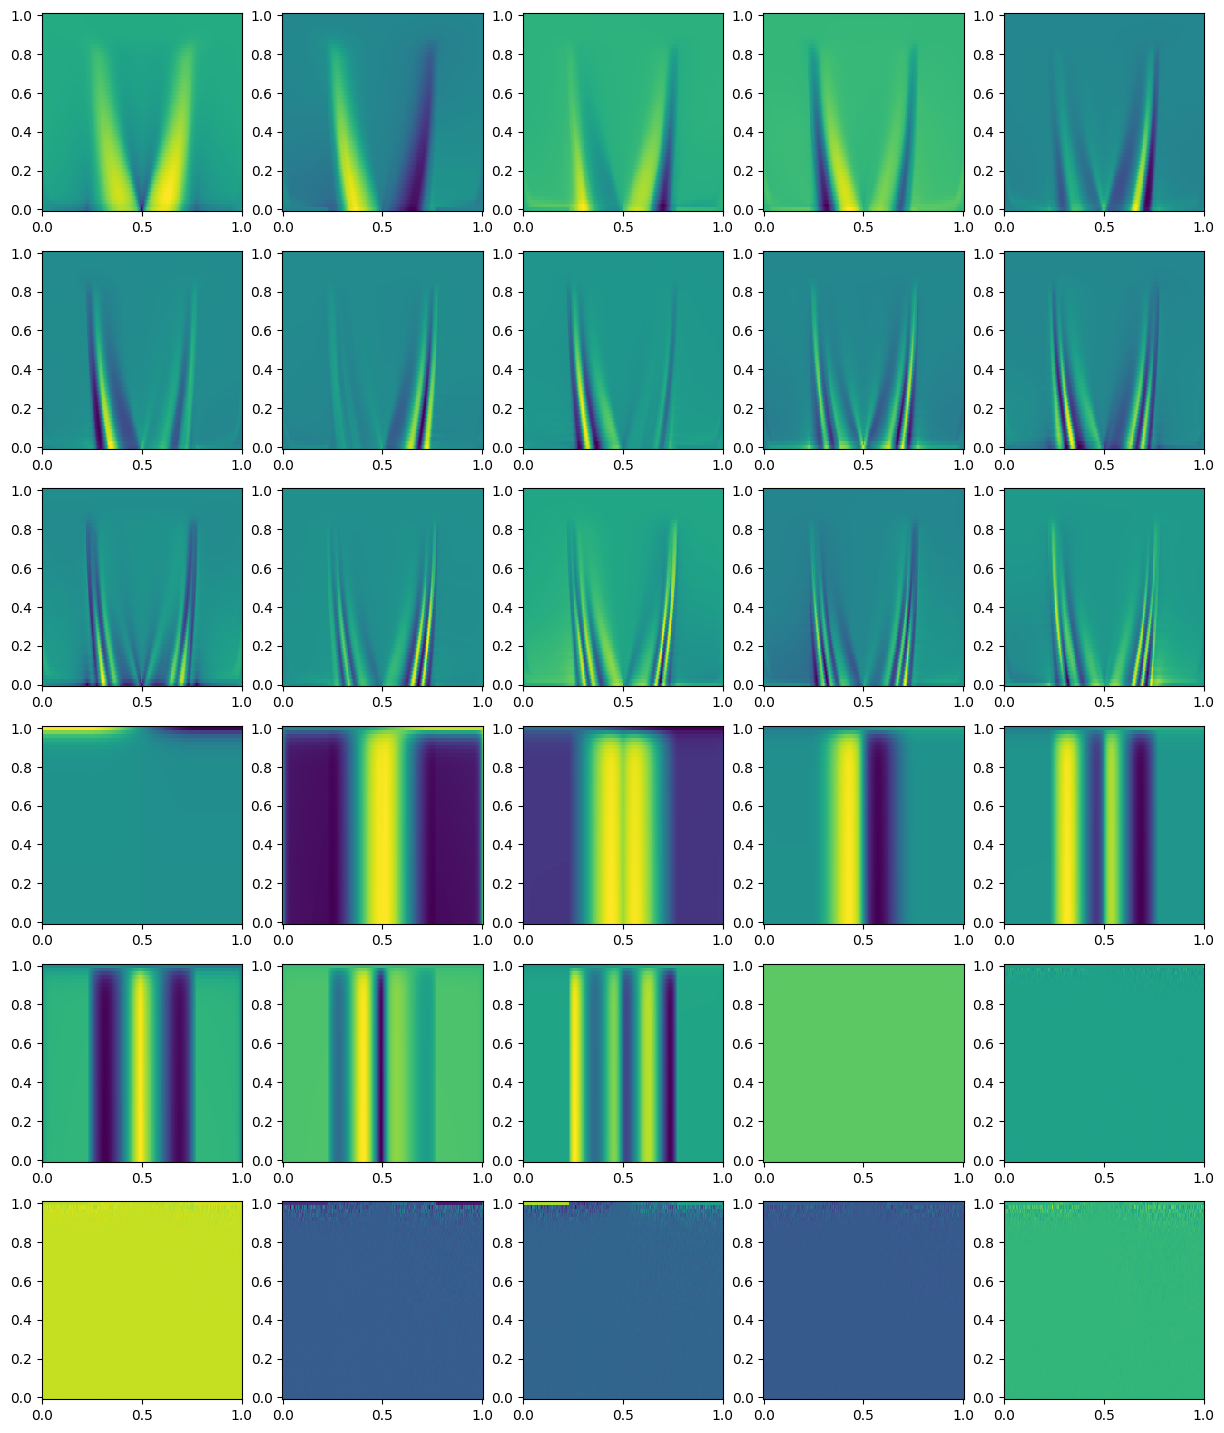

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

bases_pca_out1 = bases_pca_out.reshape(Nx,Ny,k_max).to('cpu')
wbases_pca_out1 = wbases_pca_out.reshape(Nx,Ny,k_max).to('cpu')
bases_pca_in = bases_pca_in_2.reshape(Nx,Ny,k_max).to('cpu')
wbases_pca_in = wbases_pca_in_2.reshape(Nx,Ny,k_max).to('cpu')
mygridx = np.linspace(0, L, Nx)
mygridy = np.linspace(0, L, Ny)
grid_x, grid_y = np.meshgrid(mygridx, mygridy)
m=6
n=5
fig, axs = plt.subplots(m, n, figsize=(3*n,3*m))
for i in range(5):
    axs[0,i].pcolormesh(grid_x.T, grid_y.T, bases_pca_out1[:,:,i])
    axs[1,i].pcolormesh(grid_x.T, grid_y.T, bases_pca_out1[:,:,i+5])
    axs[2,i].pcolormesh(grid_x.T, grid_y.T, bases_pca_out1[:,:,i+10])
    axs[3,i].pcolormesh(grid_x.T, grid_y.T, bases_pca_in[:,:,i])
    axs[4,i].pcolormesh(grid_x.T, grid_y.T, bases_pca_in[:,:,i+5])
    axs[5,i].pcolormesh(grid_x.T, grid_y.T, bases_pca_in[:,:,i+10])
# fig.suptitle(' ', y=0.98)
# plt.tight_layout()
plt.show()

torch.Size([11271, 96])


C:\Users\15461\AppData\Local\Temp\ipykernel_23680\3835810368.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


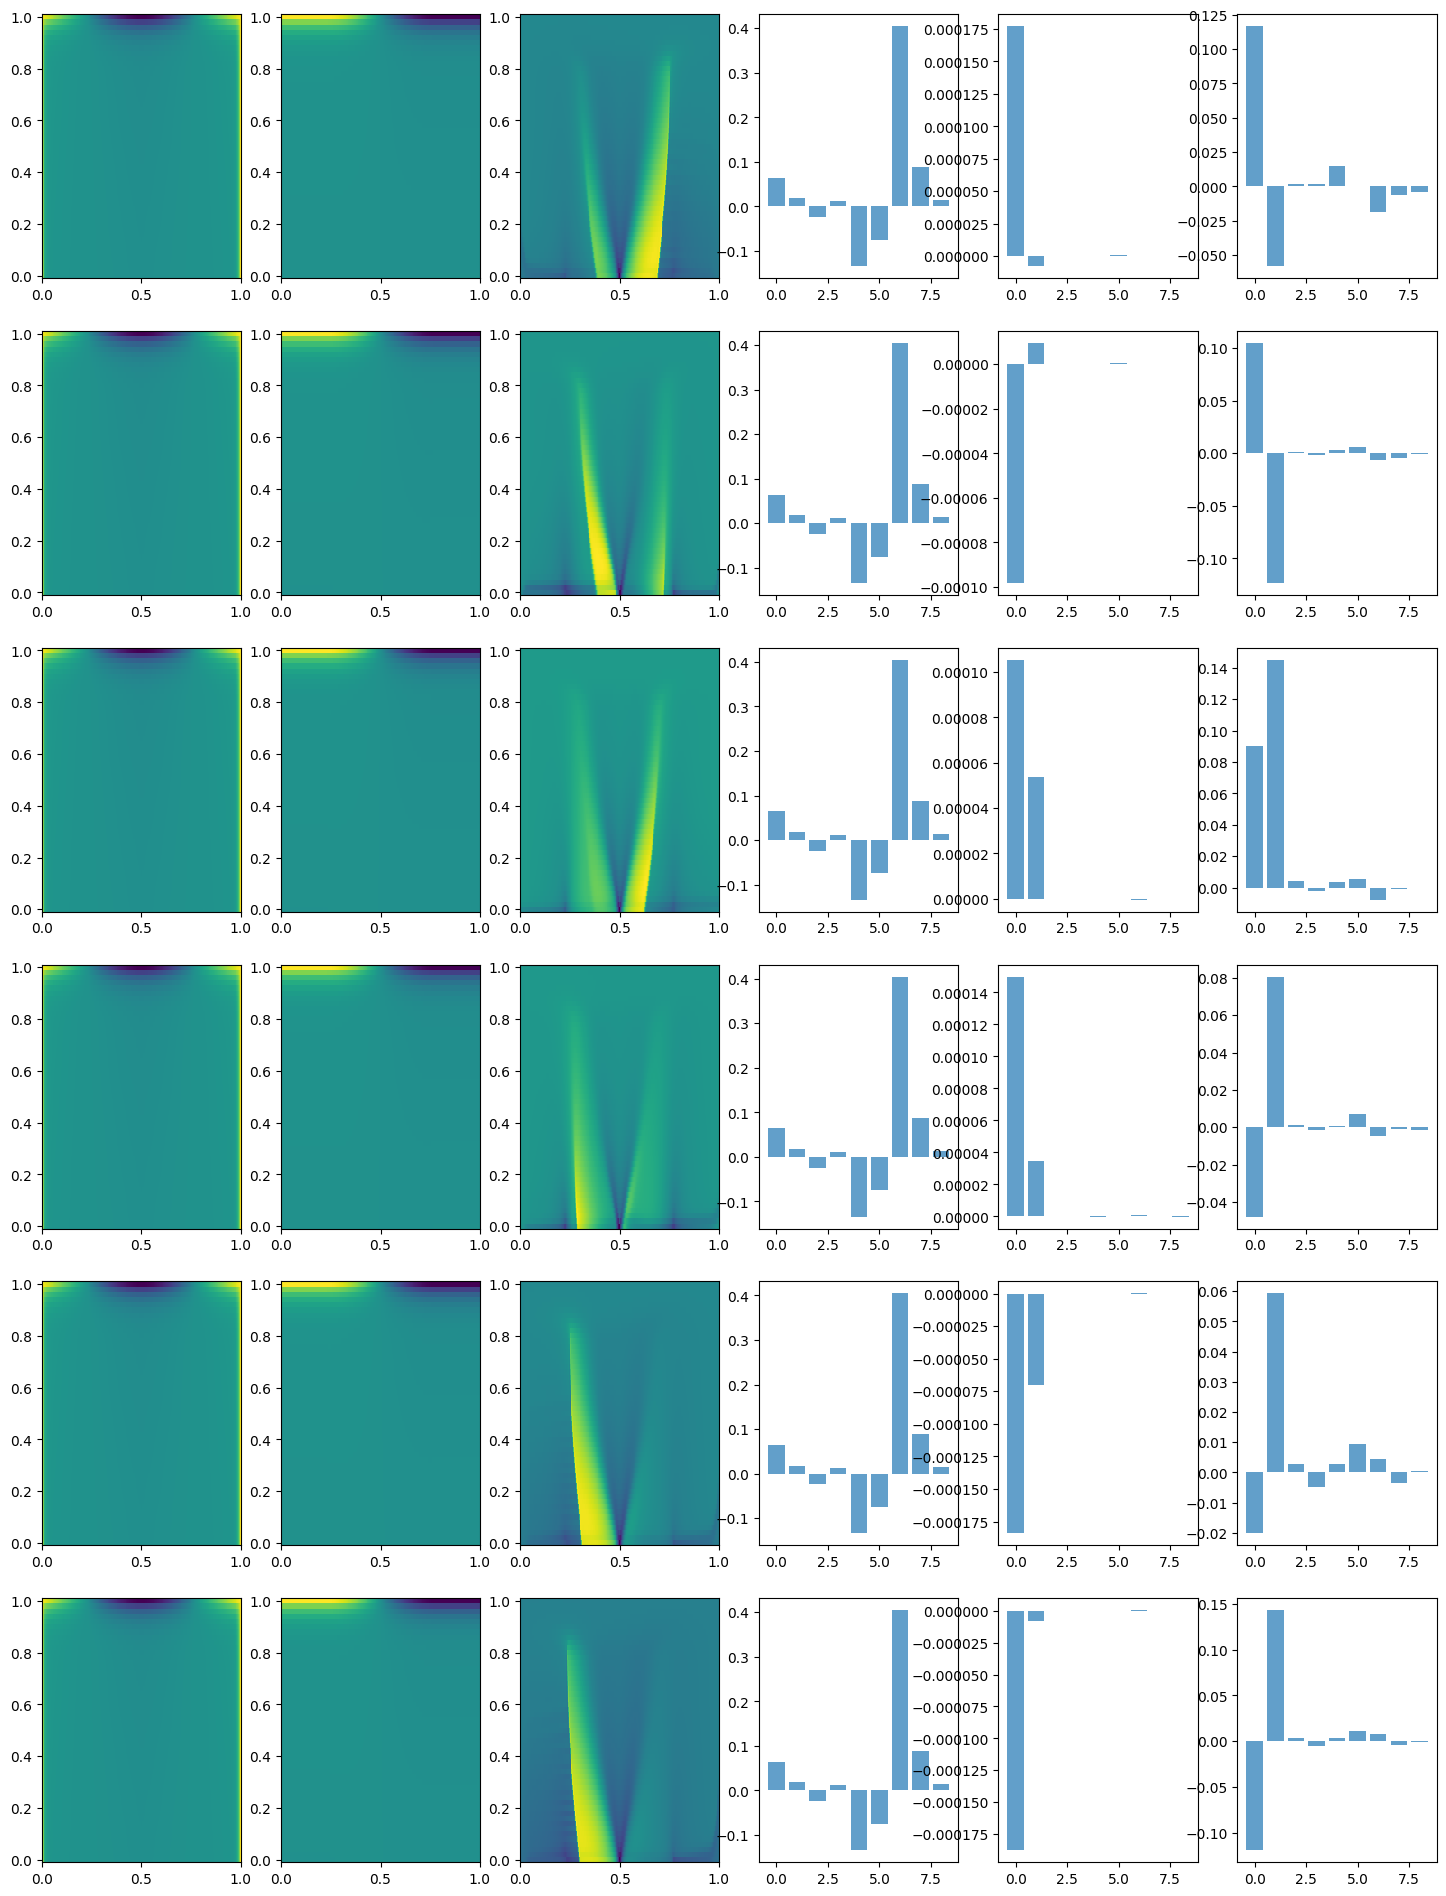

In [8]:
import matplotlib.pyplot as plt
from models.losses import LpLoss

myloss = LpLoss(d=1, p=2, size_average=False)


m=6
n=6
fig, axs = plt.subplots(m, n, figsize=(3*n,4*m))#宽度、高度
k1=6
k2=15
  
# wbases = wbases_pca_out.to('cpu')
wbases = wbases_pca_in_2.to('cpu')
print(wbases.shape)
with torch.no_grad():
    for index in range(m):

        x = x_test[index]   #221*51,3
        x = x_normalizer.encode(x).to('cpu')
        x0 = x[:,0].reshape(221,51) 
        x1 = x[:,1].reshape(221,51) 

        y = y_test[index]
        y = y_normalizer.encode(y).to('cpu')  #221*51,1
        y0 = y[:,0].reshape(221,51)
        axs[index,0].pcolormesh(grid_x.T, grid_y.T, x0)
        axs[index,1].pcolormesh(grid_x.T, grid_y.T, x1)
        axs[index,2].pcolormesh(grid_x.T, grid_y.T, y0)
        x0_hat = torch.einsum("x,xk->k", x[:,0], wbases)[k1:k2]
        x1_hat = torch.einsum("x,xk->k", x[:,1], wbases)[k1:k2]
        y_hat = torch.einsum("x,xk->k", y[:,0], wbases)[k1:k2]
        x_range = range(len(x0_hat))
        axs[index,3].bar(x_range, x0_hat,align='center', alpha=0.7)
        axs[index,4].bar(x_range, x1_hat,align='center', alpha=0.7)
        axs[index,5].bar(x_range, y_hat,align='center', alpha=0.7)
        # axs[index, 0].set_title('12'.format(index + 1),pad=2)


# fig.suptitle('x,x0,x1,x2,x3,y', y=0.98)

fig.show()
